<a href="https://colab.research.google.com/github/1221206/Parameter-Estimation-Li-ion-cells-by-EIS/blob/main/WRC_parametrization_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
from google.colab import drive
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt


drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [ ]:
eis = pd.read_excel('./EIS_Opr.xlsx', sheet_name = '90SoC', skiprows = 1)

In [ ]:
eis.head()

,Sl. No.,Frequency (Hz),R (ohm),X (ohm),Voltage (V),Sl. No..1,Frequency (Hz).1,R (ohm).1,X (ohm).1,Voltage (V).1,...,Sl. No..6,Frequency (Hz).6,R (ohm).6,X (ohm).6,Voltage (V).6,Sl. No..7,Frequency (Hz).7,R (ohm).7,X (ohm).7,Voltage (V).7
0,1,1000.0,0.015132,0.000924,4.07873,1,1000.0,0.015204,0.000524,4.07753,...,1,1000.0,0.016956,-0.002207,4.07251,NaN,NaN,NaN,NaN,NaN
1,2,910.0,0.015160,0.000810,4.07873,2,910.0,0.015261,0.000400,4.07753,...,2,910.0,0.017141,-0.002487,4.07251,NaN,NaN,NaN,NaN,NaN
2,3,830.0,0.015188,0.000705,4.07873,3,830.0,0.015321,0.000287,4.07753,...,3,830.0,0.017330,-0.002760,4.07251,NaN,NaN,NaN,NaN,NaN
3,4,760.0,0.015213,0.000619,4.07873,4,760.0,0.015373,0.000195,4.07753,...,4,760.0,0.017520,-0.003016,4.07251,NaN,NaN,NaN,NaN,NaN
4,5,690.0,0.015246,0.000530,4.07873,5,690.0,0.015436,0.000098,4.07753,...,5,690.0,0.017737,-0.003292,4.07251,NaN,NaN,NaN,NaN,NaN


In [ ]:
case1 = eis.iloc[:,11:14].values  # Temp = 30 C (11:16)

In [ ]:
W = case1[:,0] * 2 * np.pi  # w = 2 pi f
Y1 = case1[:,1] + np.random.randn(len(case1))*1e-5
Y2 = -case1[:,2] + np.random.randn(len(case1))*1e-5

In [ ]:
import torch
import torch.optim as optim

In [ ]:
# warburg parallel with capacitor

def warburg_real(x, w, r, X):
    denom = (x[3]*w*x[2] + np.sqrt(w))**2 + (w**2)*(x[2]**2)*((x[1]*np.sqrt(w) + x[3])**2)

    Zreal = (((x[1]*np.sqrt(w) + x[3])*(x[3]*w*x[2]+np.sqrt(w))+ (x[3]*w*x[2])*(x[1]*np.sqrt(w)+ x[3]))/(denom)) + x[0]
    Zimag = (w*x[2]*((x[1]*np.sqrt(w)+ x[3])**2) + x[3]*(x[3]*w*x[2]+ np.sqrt(w)))/(denom)

    return torch.stack((Zreal, Zimag), dim=1)

In [ ]:
# Define your loss function

def my_loss_function(prediction, target):
    #return torch.sum((prediction[:,0] - target[:,0]) ** 2 + (prediction[:,1] - target[:,1]) ** 2)  # unweighted

    return torch.sum(((prediction[:,0] - target[:,0]) ** 2 + (prediction[:,1] - target[:,1]) ** 2)/(target[:,0] ** 2 + target[:,1] ** 2)) # amplitude weight

  # return torch.sum(((prediction[:,0] - target[:,0])/target[:,0]) ** 2 + ((prediction[:,1] - target[:,1])/target[:,1]) ** 2) # parametric weight


In [ ]:
t = np.c_[Y1,Y2]
t.shape

(100, 2)

In [ ]:
# without regularization

params = torch.tensor([0.01,0.01,0.1,0.0001], requires_grad=True)  # r0,r1,c1,a
# Define your target value (example)
target = torch.tensor(t , requires_grad=True, dtype=torch.float32)          # requires_grad=true for Adam

# Define an optimizer
optimizer = optim.Adam([params], lr=.001)  # lr is the learning rate

W1 = torch.tensor(case1[:,0] * 2 * np.pi, dtype=torch.float32)
R1 = torch.tensor(case1[:,1], dtype=torch.float32)
X1 = torch.tensor(-case1[:,2], dtype=torch.float32)

# Optimization loop
for _ in range(10000):
    # Forward pass: compute predicted value by passing data through the model
    prediction = warburg_real(params, W1, R1, X1)

    # Compute the loss
    loss = my_loss_function(prediction, target)
    print(loss)    # print(loss) for Adam, loss.item() fro SGD

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Optimized parameters:", params)

Streaming output truncated to the last 5000 lines.
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081, grad_fn=<SumBackward0>)
tensor(0.0081

In [ ]:
# with regularization

params = torch.tensor([0.01,0.01,0.1,0.0001], requires_grad=True)  # r0,r1,c1,a
# Define your target value (example)
target = torch.tensor(t , requires_grad=True, dtype=torch.float32)          # requires_grad=true for Adam

# Define an optimizer
optimizer = optim.Adam([params], lr=.001)

W1 = torch.tensor(case1[:,0] * 2 * np.pi, dtype=torch.float32)
R1 = torch.tensor(case1[:,1], dtype=torch.float32)
X1 = torch.tensor(-case1[:,2], dtype=torch.float32)

lambda_reg= 0.01
# Optimization loop
for _ in range(1000):
    # Forward pass: compute predicted value by passing data through the model
    prediction = warburg_real(params, W1, R1, X1)

    # Compute the loss
    loss = my_loss_function(prediction, target)
    total_loss = loss + lambda_reg*(torch.sum(params**2))
    print(total_loss)    # print(loss) for Adam, loss.item() fro SGD

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

print("Optimized parameters:", params)

tensor(2.9667, grad_fn=<AddBackward0>)
tensor(2.1218, grad_fn=<AddBackward0>)
tensor(1.3729, grad_fn=<AddBackward0>)
tensor(0.9156, grad_fn=<AddBackward0>)
tensor(0.5657, grad_fn=<AddBackward0>)
tensor(0.3112, grad_fn=<AddBackward0>)
tensor(0.1637, grad_fn=<AddBackward0>)
tensor(0.0983, grad_fn=<AddBackward0>)
tensor(0.1135, grad_fn=<AddBackward0>)
tensor(0.1807, grad_fn=<AddBackward0>)
tensor(0.2478, grad_fn=<AddBackward0>)
tensor(0.2952, grad_fn=<AddBackward0>)
tensor(0.3215, grad_fn=<AddBackward0>)
tensor(0.3267, grad_fn=<AddBackward0>)
tensor(0.3276, grad_fn=<AddBackward0>)
tensor(0.3379, grad_fn=<AddBackward0>)
tensor(0.3513, grad_fn=<AddBackward0>)
tensor(0.3634, grad_fn=<AddBackward0>)
tensor(0.3716, grad_fn=<AddBackward0>)
tensor(0.3690, grad_fn=<AddBackward0>)
tensor(0.3598, grad_fn=<AddBackward0>)
tensor(0.3529, grad_fn=<AddBackward0>)
tensor(0.3485, grad_fn=<AddBackward0>)
tensor(0.3473, grad_fn=<AddBackward0>)
tensor(0.3483, grad_fn=<AddBackward0>)
tensor(0.3444, grad_fn=<A

In [ ]:
# Compute the Hessian matrix using torch.autograd.functional.hessian
def loss_with_regularization(params, W1, R1, X1, target, lambda_reg):
    prediction = warburg_real(params, W1, R1, X1)
    loss = my_loss_function(prediction, target)
    l2_reg = lambda_reg * torch.sum(params ** 2)
    total_loss = loss + l2_reg
    return total_loss

final_loss = loss_with_regularization(params, W1, R1, X1, target, lambda_reg)
hessian_matrix = torch.autograd.functional.hessian(lambda p: loss_with_regularization(p, W1, R1, X1, target, lambda_reg), params)

# Calculate the covariance matrix as the inverse of the Hessian
covariance_matrix = torch.inverse(hessian_matrix)

print("Covariance matrix:", covariance_matrix)

# Calculate standard errors and relative errors
standard_errors = torch.sqrt(torch.diag(covariance_matrix))
relative_errors = (standard_errors / params) * 100  # Error % as a percentage

print("Standard errors:", standard_errors)
print("Relative errors (%):", relative_errors)

Covariance matrix: tensor([[ 9.2962e-06, -8.1057e-06,  1.8573e-03, -9.0793e-07],
        [-8.1057e-06,  1.0304e-05, -1.5597e-03, -1.7857e-06],
        [ 1.8573e-03, -1.5597e-03,  6.8068e-01, -2.4895e-04],
        [-9.0793e-07, -1.7857e-06, -2.4896e-04,  7.5448e-06]])
Standard errors: tensor([0.0030, 0.0032, 0.8250, 0.0027])
Relative errors (%): tensor([ 19.5441, 116.4777, 283.9537, 176.4993], grad_fn=<MulBackward0>)


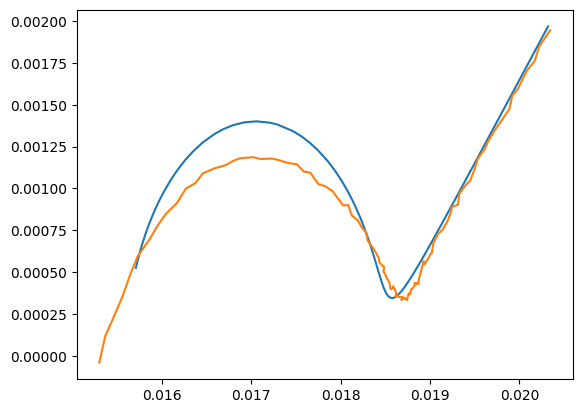

In [ ]:
def warburg_chk(x, w):
  #x = [R0,R1,C1,A]
    x = x.detach().numpy()

    denom = (x[3]*w*x[2] + np.sqrt(w))**2 + (w**2)*(x[2]**2)*((x[1]*np.sqrt(w) + x[3])**2)

    Zreal = ((x[1]*np.sqrt(w) + x[3])*(x[3]*w*x[2]+np.sqrt(w))+ (x[3]*w*x[2])*(x[1]*np.sqrt(w)+ x[3]))/(denom) + x[0]
    Zimag = (w*x[2]*((x[1]*np.sqrt(w)+ x[3])**2) + x[3]*(x[3]*w*x[2]+ np.sqrt(w)))/denom

    return Zreal,Zimag

Zre, neg_Zim = warburg_chk(params, W)
plt.plot(Zre, neg_Zim)
plt.plot(Y1, Y2)